In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics

from src.reasoner_mod import *
from src.generate import load_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *

In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)

emb_size = 10
hidden_size = 16
epoch_count = 11
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)

trained_reasoner = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [ModifiedEmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')

train_logger = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count, batch_size=batch_size, not_nn_loss_weight=100, and_nn_loss_weight=50)

created reasoner with 3283 parameters
created 40 encoders with 1270 parameters each
train epoch 00/11 | batch 2001/2000 | loss 4.1859 | val loss 0.7716 | acc 0.2131 | f1 0.3514 | prec 0.2131 | recall 1.0000 | roc auc 0.5142 | pr auc 0.2463 | elapsed 33.61s
train epoch 01/11 | batch 2001/2000 | loss 3.0575 | val loss 0.5406 | acc 0.7973 | f1 0.0939 | prec 0.9882 | recall 0.0493 | roc auc 0.5050 | pr auc 0.2769 | elapsed 82.08s
train epoch 02/11 | batch 2001/2000 | loss 2.1145 | val loss 0.4757 | acc 0.8170 | f1 0.2504 | prec 0.9859 | recall 0.1434 | roc auc 0.6426 | pr auc 0.4489 | elapsed 82.99s
train epoch 03/11 | batch 2001/2000 | loss 1.8555 | val loss 0.4451 | acc 0.8246 | f1 0.3334 | prec 0.8764 | recall 0.2059 | roc auc 0.7127 | pr auc 0.5198 | elapsed 89.16s
train epoch 04/11 | batch 2001/2000 | loss 1.7418 | val loss 0.4024 | acc 0.8378 | f1 0.4529 | prec 0.8057 | recall 0.3150 | roc auc 0.7827 | pr auc 0.6153 | elapsed 89.94s
train epoch 05/11 | batch 2001/2000 | loss 1.6488 |

In [4]:
not_nn = trained_reasoner.not_nn
top = trained_reasoner.top_concept[0]
bot = trained_reasoner.bot_concept[0]
optimizer = T.optim.AdamW(not_nn.parameters(), 0.0001)

for i in range(30000):
    optimizer.zero_grad()
    input1 = T.rand(10)

    loss = (F.mse_loss(input1, not_nn(not_nn(input1))))
    loss+=(F.mse_loss(top, not_nn(bot)))
    loss+=(F.mse_loss(bot, not_nn(top)))

    if i%5000==0:
        print("loss: ", loss)
    loss.backward()
    optimizer.step()

trained_reasoner.not_nn = not_nn

loss:  tensor(0.6542, grad_fn=<AddBackward0>)


loss:  tensor(0.0147, grad_fn=<AddBackward0>)
loss:  tensor(0.0006, grad_fn=<AddBackward0>)
loss:  tensor(2.1451e-09, grad_fn=<AddBackward0>)
loss:  tensor(7.7539e-10, grad_fn=<AddBackward0>)
loss:  tensor(3.3067e-09, grad_fn=<AddBackward0>)


In [5]:
and_nn = trained_reasoner.and_nn
bot = trained_reasoner.bot_concept[0]
top = trained_reasoner.top_concept[0]
not_nn = trained_reasoner.not_nn
optimizer = T.optim.AdamW(and_nn.parameters(), 0.0001)

for i in range(50000):
    optimizer.zero_grad()
    input1 = T.rand(10)
    input2 = T.rand(10)
    input3 = T.rand(10)
    loss = F.mse_loss(input1, and_nn(im_mod(input1, input1)))
    loss += F.mse_loss(bot, and_nn(im_mod(bot, input1)))
    loss += F.mse_loss(input3, and_nn(im_mod(input3,top)))
    loss += F.mse_loss(bot, and_nn(im_mod(input2, not_nn(input2))))

    if i%10000==0:
        print("loss: ", loss)
    loss.backward()
    optimizer.step()

trained_reasoner.and_nn = and_nn

loss:  tensor(0.7698, grad_fn=<AddBackward0>)
loss:  tensor(0.0152, grad_fn=<AddBackward0>)
loss:  tensor(0.0089, grad_fn=<AddBackward0>)
loss:  tensor(0.0153, grad_fn=<AddBackward0>)
loss:  tensor(0.0212, grad_fn=<AddBackward0>)


In [6]:
train_logger = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=4, batch_size=batch_size, not_nn_loss_weight=100, top_bot_weight=18, and_nn_loss_weight=40, train_top_bot=True)

train epoch 0/4 | batch 2001/2000 | loss 9.2767 | val loss 0.2350 | acc 0.9151 | f1 0.7972 | prec 0.8122 | recall 0.7827 | roc auc 0.9368 | pr auc 0.8841 | elapsed 94.16s
train epoch 1/4 | batch 2001/2000 | loss 8.8484 | val loss 0.1970 | acc 0.9337 | f1 0.8322 | prec 0.9043 | recall 0.7707 | roc auc 0.9472 | pr auc 0.9064 | elapsed 117.55s
train epoch 2/4 | batch 2001/2000 | loss 8.6752 | val loss 0.1935 | acc 0.9361 | f1 0.8398 | prec 0.9012 | recall 0.7862 | roc auc 0.9502 | pr auc 0.9124 | elapsed 106.33s
train epoch 3/4 | batch 2001/2000 | loss 8.7562 | val loss 0.1931 | acc 0.9391 | f1 0.8480 | prec 0.9054 | recall 0.7974 | roc auc 0.9515 | pr auc 0.9159 | elapsed 107.15s
train epoch 4/4 | batch 2001/2000 | loss 8.8802 | val loss 0.1955 | acc 0.9368 | f1 0.8466 | prec 0.8771 | recall 0.8182 | roc auc 0.9539 | pr auc 0.9190 | elapsed 111.36s


In [7]:
torch.set_printoptions(precision=3)
input = T.rand(10)
print(input)
output = trained_reasoner.not_nn(trained_reasoner.not_nn(input))
print(output)
print(F.mse_loss(input, output))

tensor([0.365, 0.006, 0.083, 0.739, 0.244, 0.154, 0.551, 0.959, 0.119, 0.466])
tensor([0.362, 0.004, 0.081, 0.740, 0.243, 0.153, 0.552, 0.958, 0.119, 0.467],
       grad_fn=<SqueezeBackward3>)
tensor(1.674e-06, grad_fn=<MseLossBackward0>)


In [8]:
trained_reasoner.not_nn.weight

Parameter containing:
tensor([[-0.310,  0.169,  0.540, -0.029,  0.162, -0.170,  0.527,  0.734,  0.093,
          0.309],
        [ 0.028, -0.551, -0.032,  0.109,  0.090,  0.515, -0.036, -0.007,  0.749,
         -0.008],
        [ 0.369, -0.177, -0.043,  0.641, -0.195, -0.383,  0.003,  0.438,  0.363,
         -0.119],
        [-0.097, -0.063,  0.373, -0.233,  0.267, -0.372,  0.116, -0.420,  0.211,
         -0.500],
        [ 0.396,  0.482, -0.084,  0.054,  0.031, -0.213,  0.877, -0.240,  0.168,
          0.203],
        [-0.053,  0.704, -0.567, -0.363, -0.054,  0.022,  0.297,  0.289,  0.128,
         -0.387],
        [ 0.232,  0.376, -0.273, -0.057,  0.727, -0.111,  0.019, -0.044, -0.566,
         -0.347],
        [ 0.581,  0.148,  0.429, -0.324, -0.510,  0.320,  0.255,  0.230, -0.131,
          0.096],
        [ 0.070,  0.395,  0.283,  0.371,  0.083,  0.425, -0.375, -0.123,  0.402,
          0.277],
        [ 0.222, -0.207, -0.240, -0.709,  0.379, -0.395, -0.274, -0.211,  0.207,
      

In [9]:
print(T.round(T.matmul( trained_reasoner.not_nn.weight, trained_reasoner.not_nn.weight)*100)/100)

tensor([[1., -0., -0., -0., -0., -0., -0., 0., -0., -0.],
        [-0., 1., -0., -0., 0., -0., -0., 0., 0., -0.],
        [-0., -0., 1., -0., 0., -0., -0., 0., 0., -0.],
        [0., 0., 0., 1., -0., 0., 0., -0., -0., 0.],
        [-0., -0., -0., -0., 1., -0., -0., 0., 0., -0.],
        [-0., 0., 0., -0., -0., 1., -0., -0., -0., 0.],
        [0., 0., 0., 0., -0., 0., 1., -0., -0., 0.],
        [-0., -0., -0., -0., -0., 0., -0., 1., 0., 0.],
        [-0., 0., 0., -0., -0., 0., 0., -0., 1., 0.],
        [0., 0., 0., 0., -0., 0., 0., -0., -0., 1.]], grad_fn=<DivBackward0>)


In [10]:
print(trained_reasoner.bot_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.top_concept[0])
print(output)
print(F.mse_loss(trained_reasoner.bot_concept[0], output))

tensor([ 0.694,  0.159,  0.212, -0.369,  0.660, -0.021,  0.159,  0.191, -0.352,
        -0.401], grad_fn=<SelectBackward0>)
tensor([ 0.582,  0.156,  0.104, -0.401,  0.599, -0.122,  0.197,  0.080, -0.415,
        -0.345], grad_fn=<SqueezeBackward3>)
tensor(0.006, grad_fn=<MseLossBackward0>)


In [11]:
print(trained_reasoner.top_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.bot_concept[0])
print(output)
print(F.mse_loss(trained_reasoner.top_concept[0], output))

tensor([ 0.050, -0.440, -0.217,  0.344,  0.334,  0.293,  0.991,  0.282, -0.365,
         0.323], grad_fn=<SelectBackward0>)
tensor([ 0.114, -0.334, -0.134,  0.336,  0.292,  0.265,  1.000,  0.385, -0.255,
         0.259], grad_fn=<SqueezeBackward3>)
tensor(0.005, grad_fn=<MseLossBackward0>)


In [12]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
random_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner), ('random reasoner', random_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    if reasoner_name == 'trained reasoner':
        train_mod(data_te, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger, not_nn_loss_weight=0.1)
    #else:
        #train(data_te, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/10 | batch 1251/1250 | loss 1.1488 | val loss 1.1488 | acc 0.6440 | f1 0.3973 | prec 0.3143 | recall 0.5399 | roc auc 0.6548 | pr auc 0.4891 | elapsed 26.29s
train epoch 01/10 | batch 1251/1250 | loss 0.9718 | val loss 0.7686 | acc 0.7320 | f1 0.4774 | prec 0.4144 | recall 0.5630 | roc auc 0.7348 | pr auc 0.5621 | elapsed 44.68s
train epoch 02/10 | batch 1251/1250 | loss 0.6564 | val loss 0.5196 | acc 0.8050 | f1 0.5731 | prec 0.5469 | recall 0.6020 | roc auc 0.8140 | pr auc 0.6593 | elapsed 45.80s
train epoch 03/10 | batch 1251/1250 | loss 0.4564 | val loss 0.3693 | acc 0.8600 | f1 0.6700 | prec 0.6873 | recall 0.6536 | roc auc 0.8764 | pr auc 0.7581 | elapsed 43.94s
train epoch 04/10 | batch 1251/1250 | loss 0.3354 | val loss 0.2785 | acc 0.8971 | f1 0.7501 | prec 0.7941 | recall 0.7108 | roc auc 0.9181 | pr auc 0.8345 | elapsed 43.77s
train epoch 05/10 | batch 1251/1250 | loss 0.2609 | val loss 0.2215 | acc 0.9198 | f1 0.8025 | prec 0.8635 | recall 0.

In [13]:
with T.no_grad():
    idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch_mod(trained_reasoner, trained_test_encoders['trained reasoner'], X_te, y_te, idx_te)
    #_, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20240630T144632


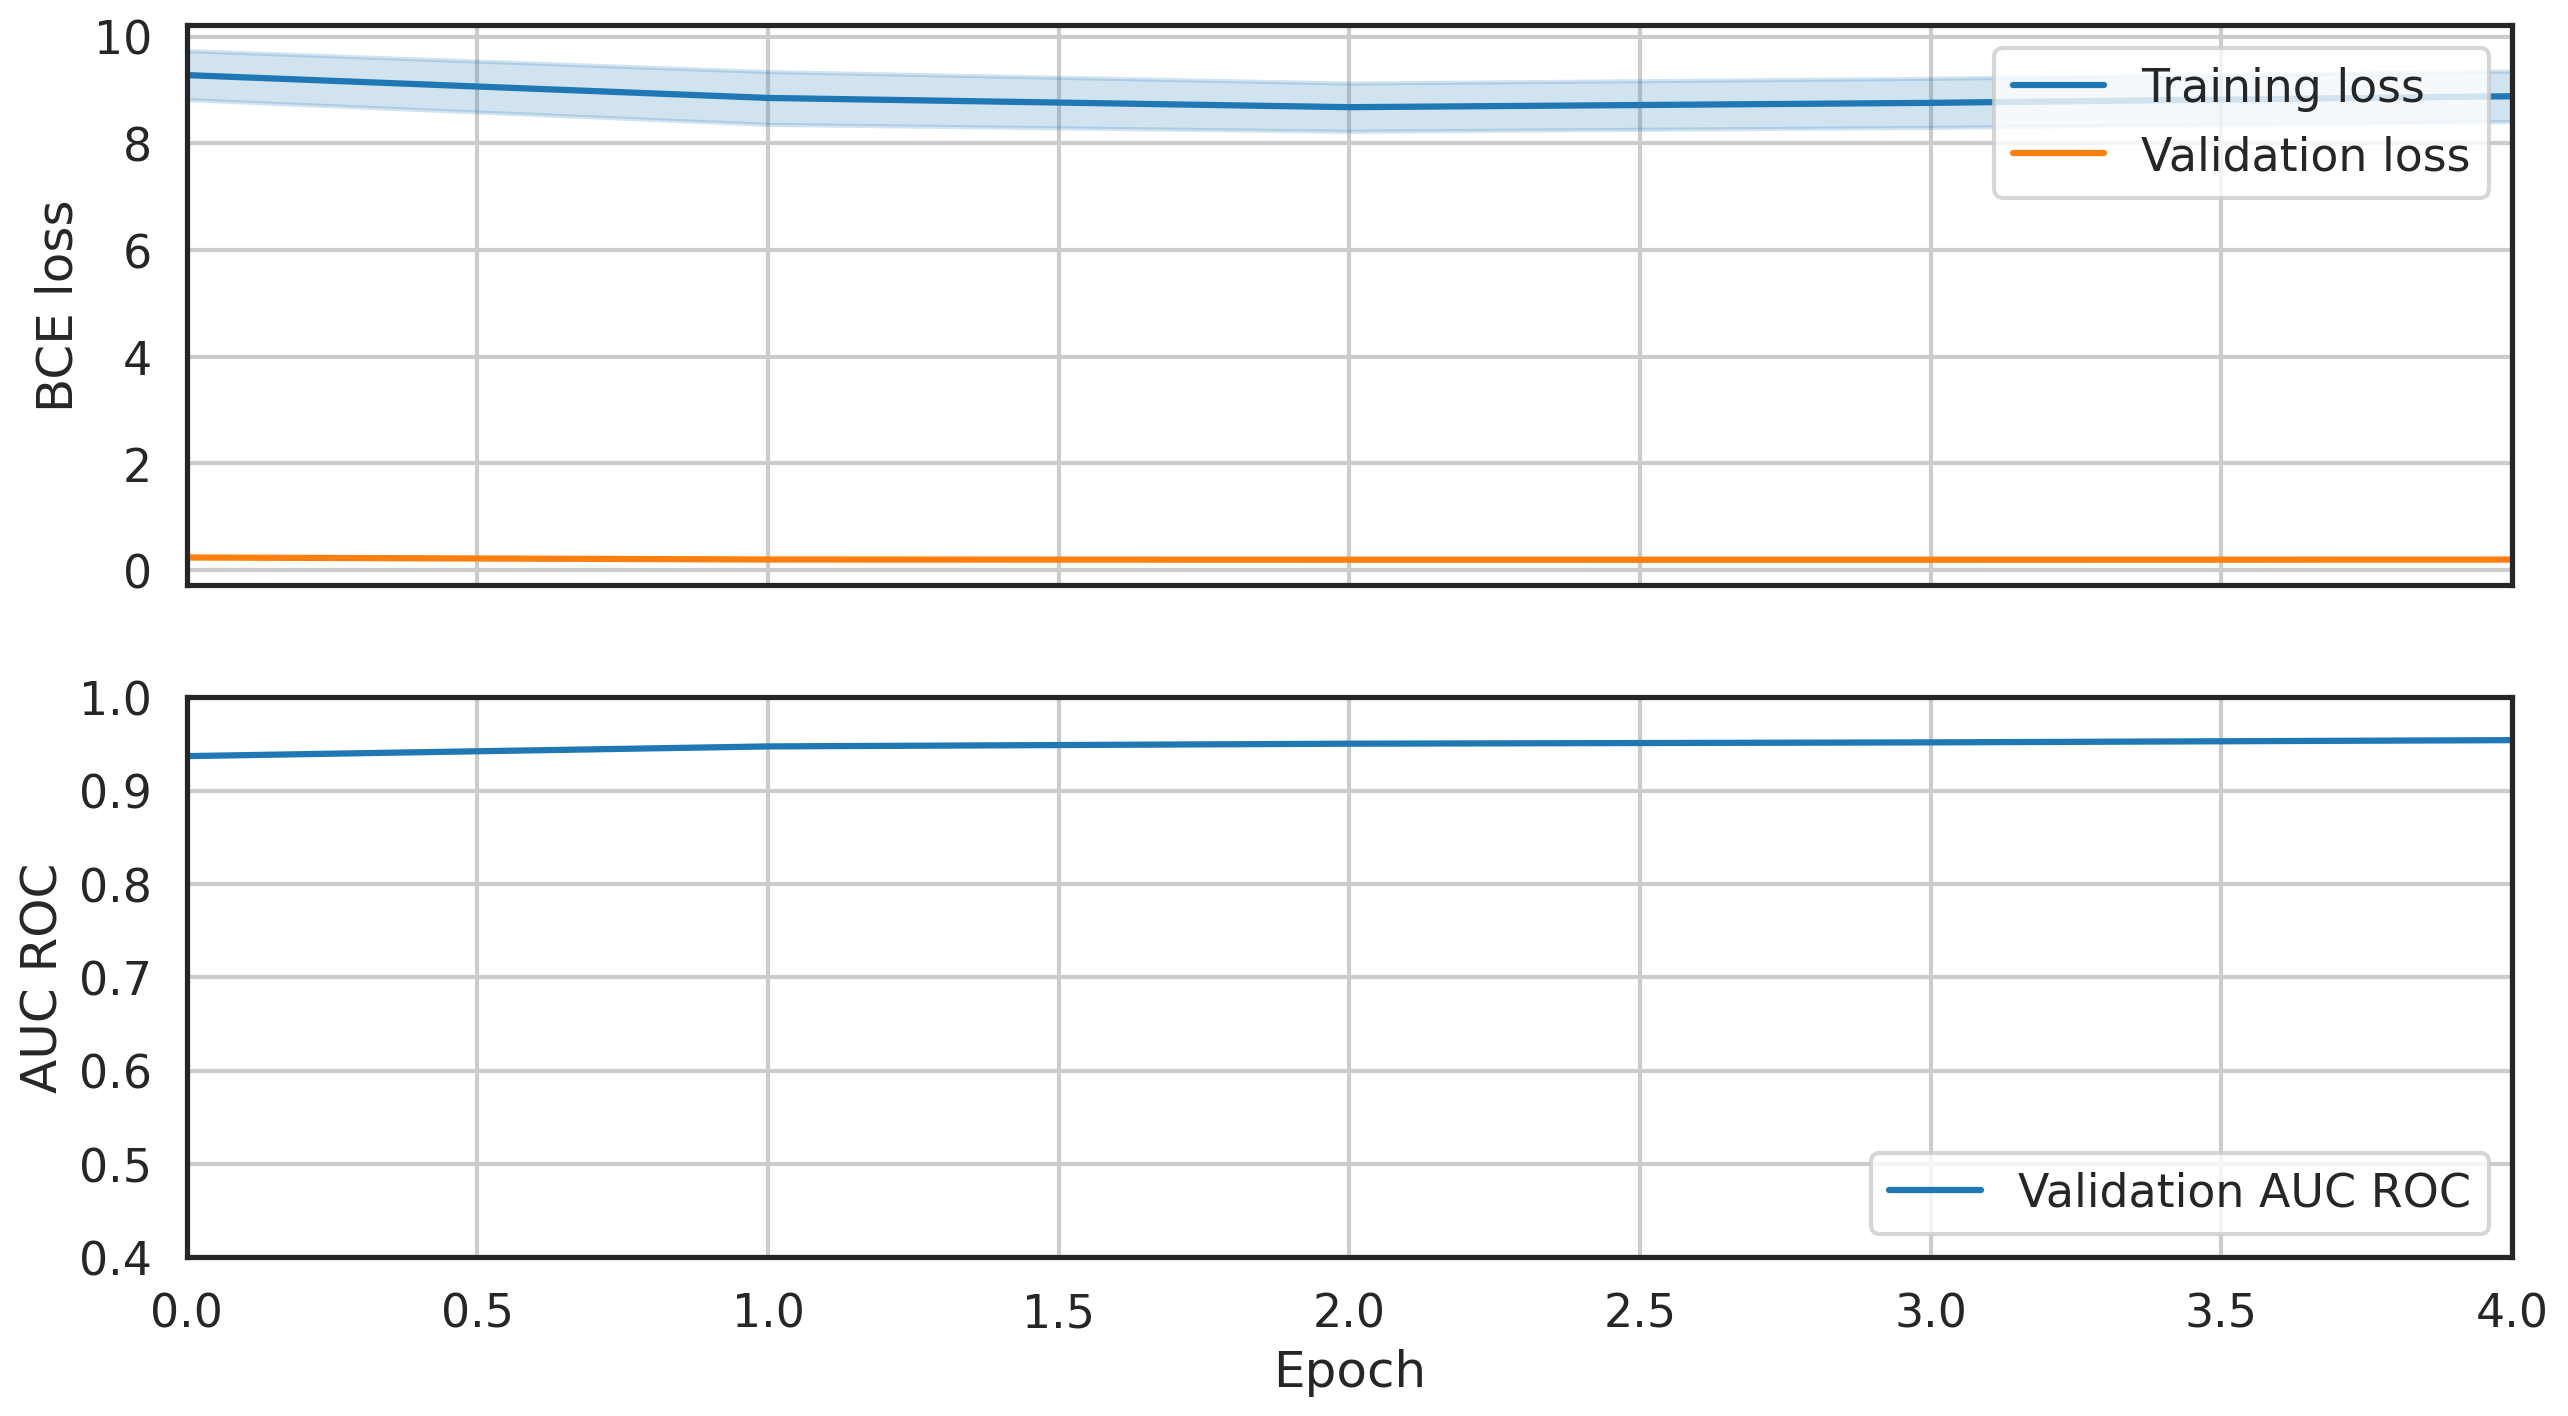

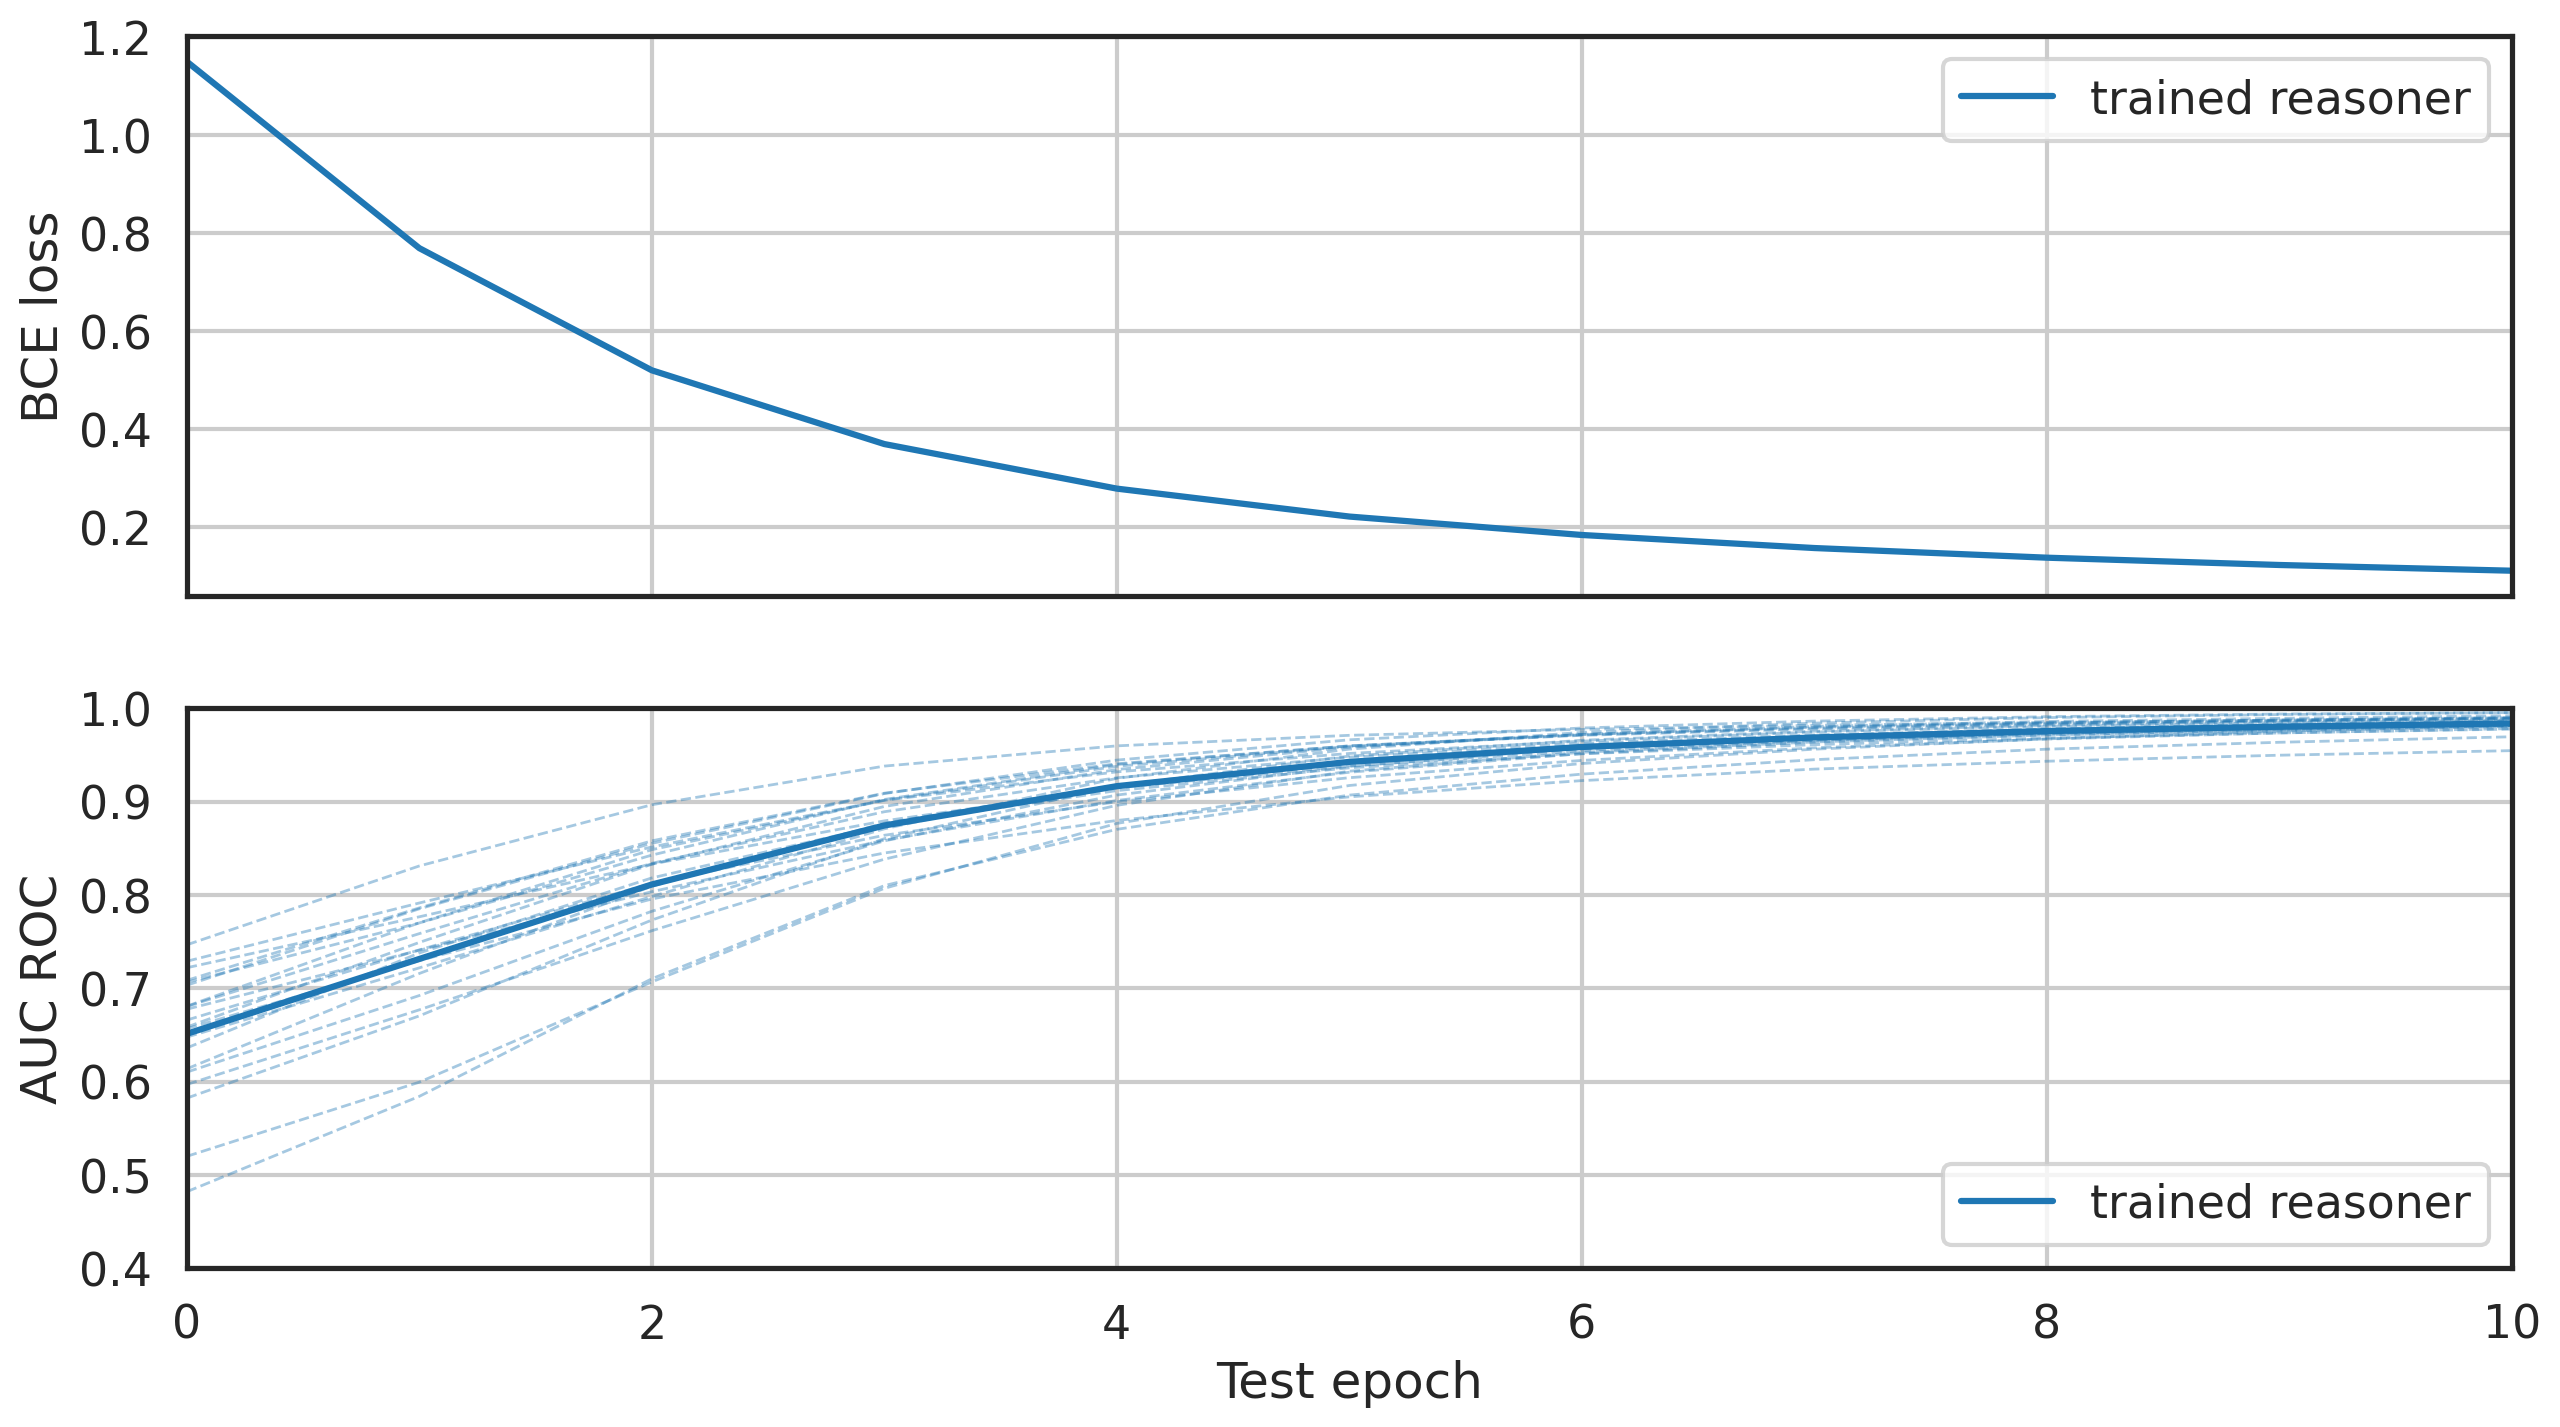

             mean       std     micro
acc      0.962425  0.016874  0.962425
prec     0.960253  0.031595  0.959852
recall   0.861555  0.048924  0.863270
f1       0.907886  0.038901  0.909003
auc_roc  0.983637  0.009378  0.984691
auc_pr   0.963804  0.019264  0.966493


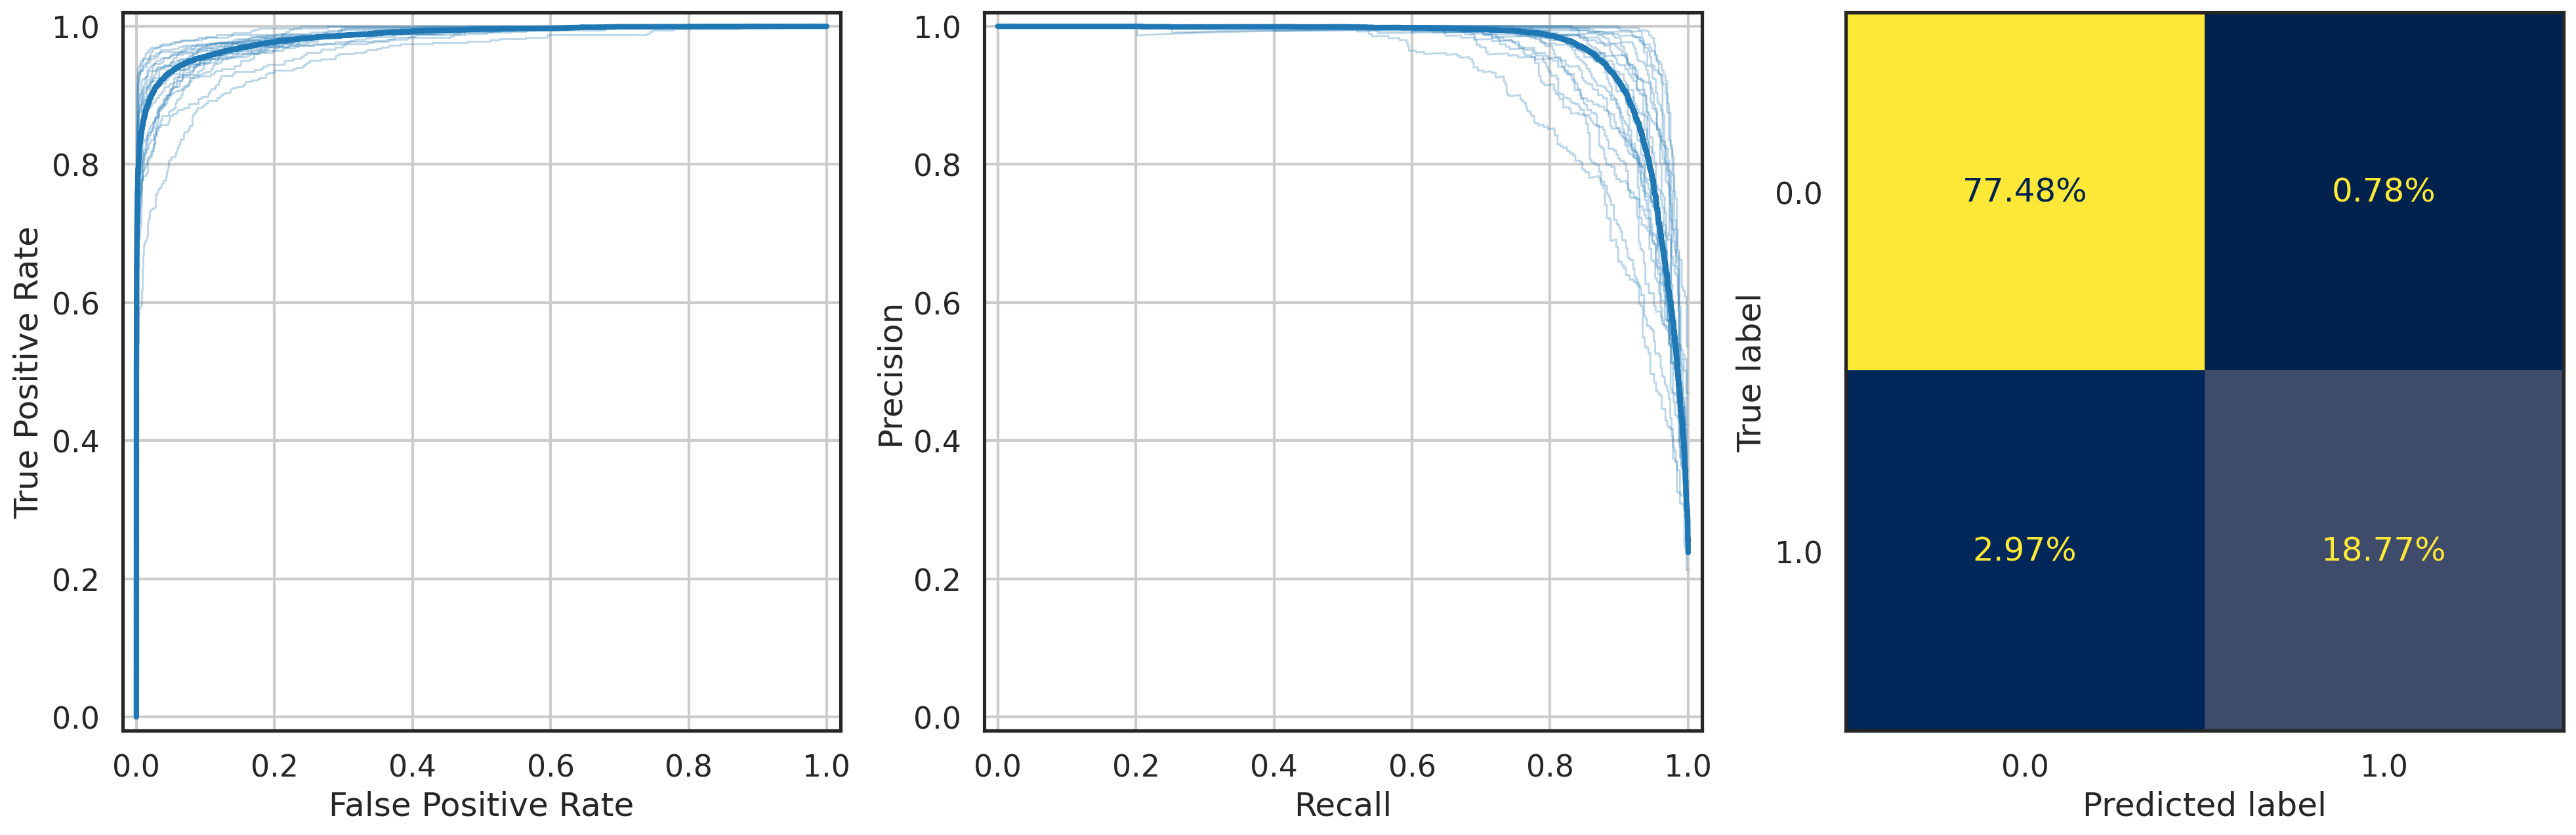

In [14]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_good=Y_te_good))#, Y_te_rand=Y_te_rand))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto, save=base+'/test.png')
print(report(test_onto, y_te, np.array(Y_te_good), idx_te, save=base+'/%-trained'))
#print(report(test_onto, y_te, np.array(Y_te_rand), idx_te, save=base+'/%-random'))

In [31]:
input = T.rand(10)

print(input)
print(trained_reasoner.and_nn(im_mod( input, input)))
F.mse_loss(input, trained_reasoner.and_nn(im_mod(input, input)))

tensor([0.356, 0.702, 0.347, 0.789, 0.441, 0.495, 0.280, 0.487, 0.882, 0.576])
tensor([0.406, 0.743, 0.250, 0.731, 0.397, 0.565, 0.299, 0.510, 0.834, 0.503],
       grad_fn=<AddBackward0>)


tensor(0.003, grad_fn=<MseLossBackward0>)

In [40]:
input = T.rand(10)

print(input)
print(trained_reasoner.bot_concept[0])
print(trained_reasoner.and_nn(im_mod(trained_reasoner.bot_concept[0], input)))
print(F.mse_loss(trained_reasoner.and_nn(im_mod(trained_reasoner.bot_concept[0], input)), trained_reasoner.bot_concept[0]))

tensor([0.625, 0.539, 0.049, 0.488, 0.863, 0.990, 0.128, 0.300, 0.789, 0.523])
tensor([ 0.694,  0.159,  0.212, -0.369,  0.660, -0.021,  0.159,  0.191, -0.352,
        -0.401], grad_fn=<SelectBackward0>)
tensor([ 0.762,  0.198,  0.144, -0.422,  0.655,  0.025,  0.249,  0.241, -0.395,
        -0.489], grad_fn=<AddBackward0>)
tensor(0.004, grad_fn=<MseLossBackward0>)


In [57]:
input = T.rand(10)

print(input)
print(trained_reasoner.and_nn(im_mod(trained_reasoner.top_concept[0], input)))
print(F.mse_loss(trained_reasoner.and_nn(im_mod(trained_reasoner.top_concept[0], input)), input))


tensor([0.069, 0.204, 0.114, 0.578, 0.677, 0.591, 0.581, 0.303, 0.215, 0.028])
tensor([ 0.226, -0.371, -0.149,  0.128,  0.308,  0.221,  0.836,  0.230, -0.423,
         0.137], grad_fn=<AddBackward0>)
tensor(0.139, grad_fn=<MseLossBackward0>)


In [86]:
input = T.rand(10)

print(trained_reasoner.bot_concept[0])
output = trained_reasoner.and_nn(im_mod(trained_reasoner.not_nn(input), input))
print(output)
print(F.mse_loss(output, input))


tensor([ 0.694,  0.159,  0.212, -0.369,  0.660, -0.021,  0.159,  0.191, -0.352,
        -0.401], grad_fn=<SelectBackward0>)
tensor([ 1.099,  0.325,  0.507, -0.177,  1.233,  0.605,  0.500,  0.728,  0.666,
        -0.620], grad_fn=<AddBackward0>)
tensor(0.241, grad_fn=<MseLossBackward0>)


In [90]:
print(trained_reasoner.bot_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.top_concept[0])
print(output)
print(F.mse_loss(trained_reasoner.bot_concept[0], output))

tensor([ 0.694,  0.159,  0.212, -0.369,  0.660, -0.021,  0.159,  0.191, -0.352,
        -0.401], grad_fn=<SelectBackward0>)
tensor([ 0.582,  0.156,  0.104, -0.401,  0.599, -0.122,  0.197,  0.080, -0.415,
        -0.345], grad_fn=<SqueezeBackward3>)
tensor(0.006, grad_fn=<MseLossBackward0>)


In [91]:
print(trained_reasoner.top_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.bot_concept[0])
print(output)
print(F.mse_loss(trained_reasoner.top_concept[0], output))

tensor([ 0.050, -0.440, -0.217,  0.344,  0.334,  0.293,  0.991,  0.282, -0.365,
         0.323], grad_fn=<SelectBackward0>)
tensor([ 0.114, -0.334, -0.134,  0.336,  0.292,  0.265,  1.000,  0.385, -0.255,
         0.259], grad_fn=<SqueezeBackward3>)
tensor(0.005, grad_fn=<MseLossBackward0>)
